## Simulate various inpainting problem

Generate a random binary matrix A of the same size of the image, with a parameter p controling the bernoulli law

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fftshift, fft, fft2, ifft2
import scipy.signal
import math
import os
from scipy.signal import gaussian
from skimage.restoration import denoise_wavelet
import pywt
from numpy import linalg

In [ ]:
!unzip '/content/nt_toolbox.zip'

In [3]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
#read image
import cv2
img = cv2.imread("/content/barbara.jpeg",cv2.IMREAD_GRAYSCALE)
img.shape

(512, 512)

### Generate a random binary matrix A of the same size of the image, with a parameter p controling the bernoulli law

In [5]:
#generating the binary matrix
p=0.7 #parameter
A=np.random.binomial(1, p, size=img.shape)
A

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 0, 1]])

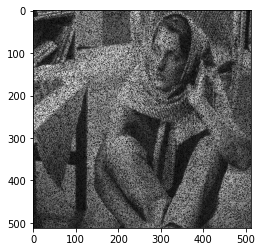

In [6]:
#plot image after applying binary matrix
plt.imshow(img*A, cmap='gray')
plt.show()

### Add gaussian noise at various level and generate the direct problem y = Ax + b



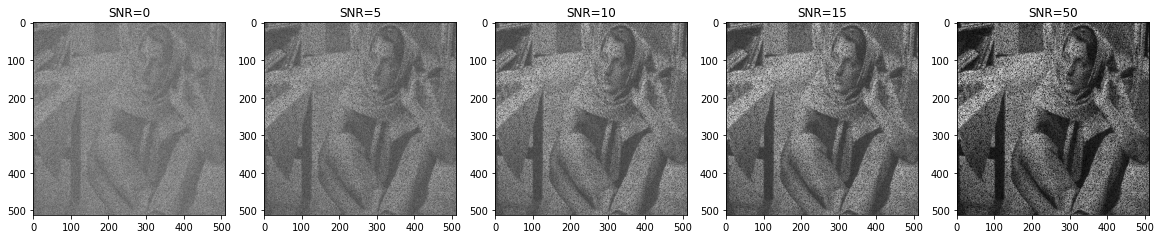

In [7]:
def add_noise(img, snr):
    ''' 
    signal: np.ndarray
    snr: float
    returns -> np.ndarray
    '''
    # calculate sigma using snr
    sigma = np.sqrt(np.var(img)/pow(10, snr/10))

    # Generate the noise
    noise = np.random.normal(0, sigma, np.shape(img))
    img = img + noise

    # return the new signal with noise
    return img


def normalize_images(data):
    normalized_img = (data-np.min(data)) / (np.max(data)-np.min(data))
    return normalized_img

img = cv2.imread("/content/barbara.jpeg",cv2.IMREAD_GRAYSCALE)
impainting_img=img*A
SNR_LIST = [0, 5, 10, 15, 50]
noisy_images = {}
# create subplots for each SNR
fig, axs = plt.subplots(1, len(SNR_LIST), figsize=(20, 5))
for i, snr in enumerate(SNR_LIST):
    # add noise to image
    noisy_img=add_noise(normalize_images(impainting_img), snr)
    noisy_images[snr] = noisy_img
    axs[i].imshow(noisy_img,cmap='gray')
    axs[i].set_title(f"SNR={snr}")
plt.show()

### Estimate x using the sparse approach we first use various wavelet orhtogonal transform

In this part, we are going to apply the **Fast Iterative Shrinkage/Thresholding algorithm**

In our setting, we have Φ∗ which is the inverse of wavelet transform, Φ which is the wavelet transform.

For simplicity, we choose a step size one.



In [27]:
# import wavelet transform function from numerical tour
from nt_toolbox.perform_wavelet_transf import *
n=512
Jmax = np.log2(n)-1
Jmin = (Jmax-3)
inv_wavelet = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=0)
wavelet = lambda f: perform_wavelet_transf(f, Jmin, +1, ti=0)

Define the soft thresholding function

In [28]:
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))
SoftThreshPsi = lambda f, T: inv_wavelet(SoftThresh(wavelet(f), T))

initialize the parameters


In [29]:
from numpy import linalg

energy = [] # to track the energy

alpha=np.zeros_like(img)
z=np.zeros_like(img)
iterations =100
lambd = .03

Iterations over original noised picture

In [30]:
def fista_SOFT(snr):
  energy = [] # to track the energy
  alpha=np.zeros_like(img)
  z=np.zeros_like(img)
  iterations =100
  lambd = .03
  for i in range(iterations):
    a=SoftThreshPsi(z+wavelet(A*(noisy_images[snr]-A*inv_wavelet(z))),lambd)
    z=a+(i/(i+5))*(a-alpha)
    alpha=a
    energy = energy + [1/2*linalg.norm(noisy_images[snr]-A*inv_wavelet(alpha),"fro")**2 + lambd*np.sum(abs(alpha))]
    denoised_image=inv_wavelet(alpha)
    
  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle(f"SNR={snr}")
  axs[0].imshow(denoised_image,cmap='gray')
  axs[1].plot(energy, linewidth=2)
  axs[1].set_xlabel("Iteration")
  axs[1].set_ylabel("E")
  
  #return energy, denoised_image

### Plot the result for different snr level and the convergence of energy curve during iterations

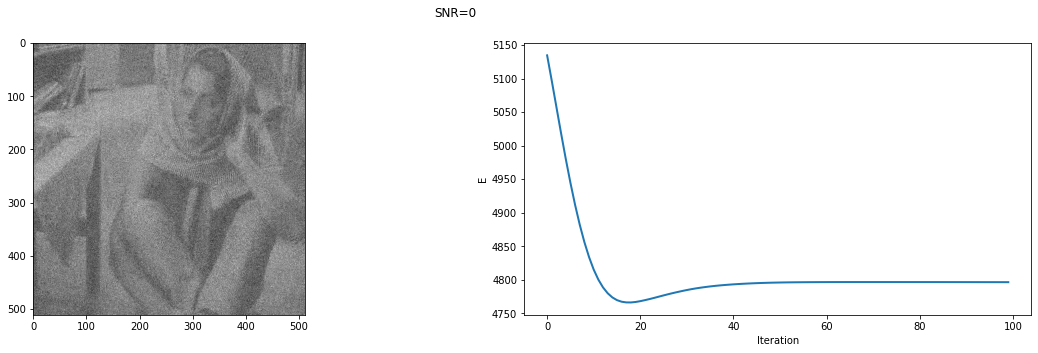

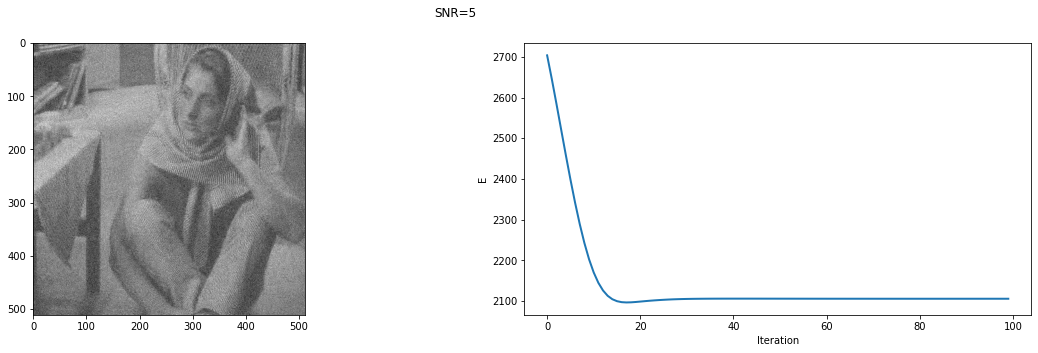

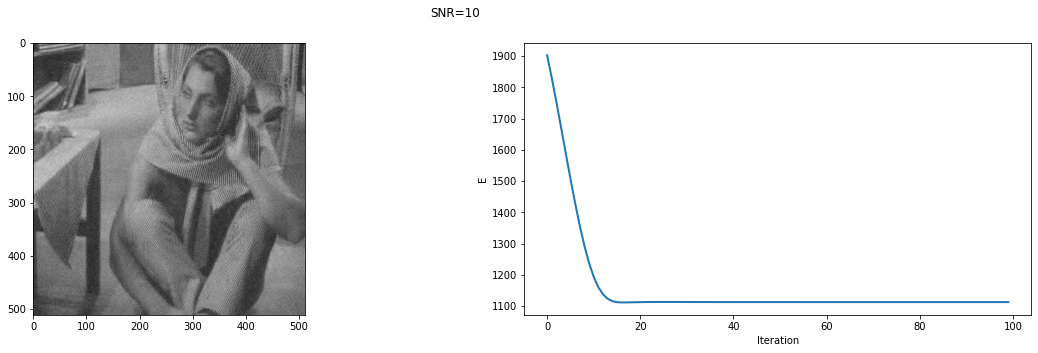

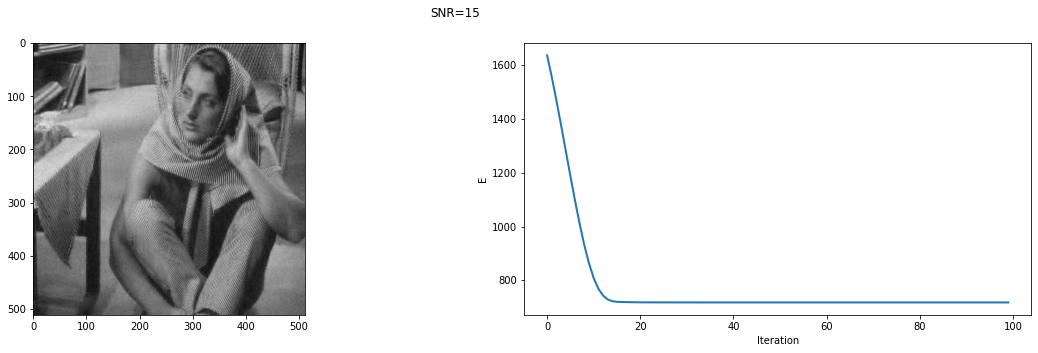

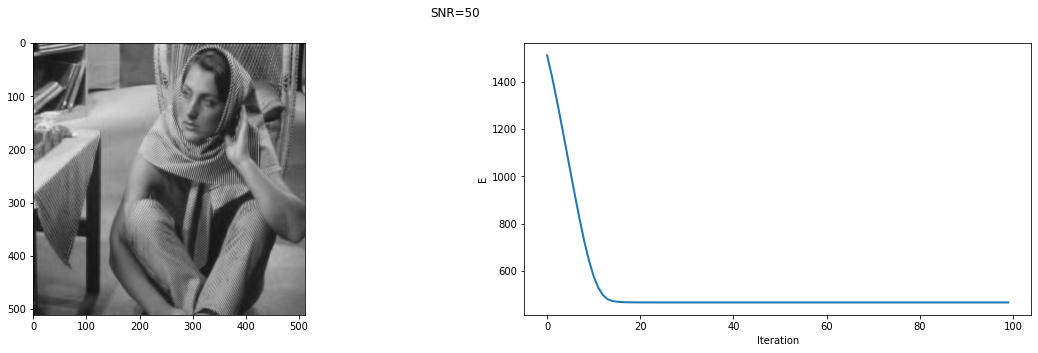

In [49]:
for snr in SNR_LIST:

  fista_SOFT(snr)

### Iterating use different lambda

In this part, we want to observe the influence of lambda on the final result

In [47]:
def FISTA_warm(snr):
  n=512
  f0 = cv2.imread("/content/barbara.jpeg",cv2.IMREAD_GRAYSCALE)
  f0 = rescale(f0[256-n//2:256+n//2,256-n//2:256+n//2])
  #initialize the parameters
  niter = 50
  lambda_list = np.linspace(.03, 0, niter)
  err = []
  iterations=30
  alpha=np.zeros_like(f0)
  z=np.zeros_like(f0)
  for lambd in lambda_list:
    z=alpha.copy()
    for i in range(iterations):
      a=SoftThreshPsi(z+wavelet(A*(noisy_images[snr]-A*inv_wavelet(z))),lambd)
      z=a+(i/(i+5))*(a-alpha)
      alpha=a
  print(inv_wavelet(alpha))
  print(pylab.norm(f0 - inv_wavelet(alpha)))

  snr_new= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - inv_wavelet(alpha)))
  plt.figure(figsize=(6,6))
  imageplot(clamp(inv_wavelet(alpha)), "Sparsity inpainting for image with snr level" + str(snr)+ ", SNR = %.1f dB" %snr_new)

[[ 0.24587635  0.17068315  0.39909354 ...  0.05340275  0.04134559
   0.05200536]
 [ 0.02967891 -0.12077037 -0.28607069 ... -0.17004089 -0.22009902
   0.2480834 ]
 [ 0.08260005  0.209487    0.08348816 ... -0.33852101  0.5384123
   1.07041139]
 ...
 [ 0.00797842 -0.03857683  0.02169155 ...  0.49037078  0.03636441
   0.15448402]
 [-0.44496451  0.06433295 -0.22675952 ...  0.43912766  0.48232849
  -0.40066398]
 [ 0.40487682  0.22203588  0.53659334 ... -0.04785371 -0.02820588
   0.88366467]]
135.93164377692236
[[ 0.19174987  0.1596958  -0.00957393 ...  0.15648432  0.25385615
   0.14580227]
 [ 0.09175501  0.06272131  0.10697093 ...  0.16475924  0.03819521
   0.47928305]
 [-0.12640153  0.03879525  0.21400112 ...  0.18539351  0.18558781
   0.49386999]
 ...
 [ 0.30224786  0.06875733  0.26601878 ...  0.53655547  0.15335049
   0.39271792]
 [ 0.1871628   0.23040919 -0.0295499  ...  0.25028131  0.50878904
   0.35372925]
 [ 0.05363766  0.15160865  0.3278996  ...  0.27816387  0.44929968
   0.21052277]

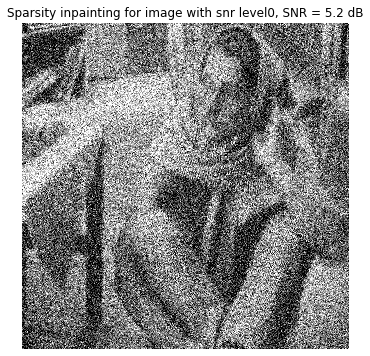

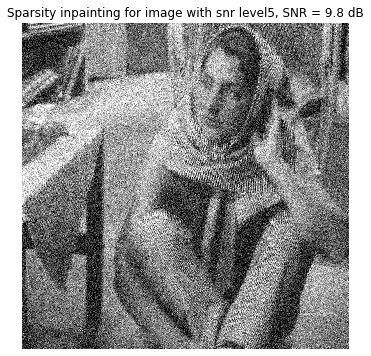

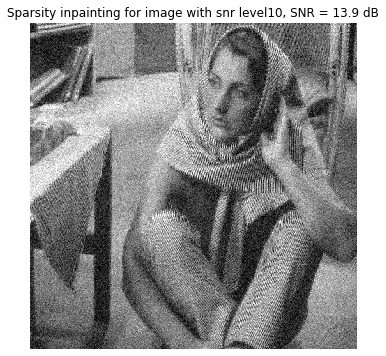

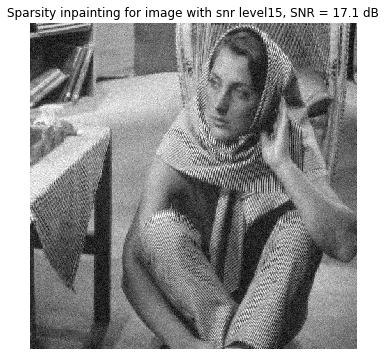

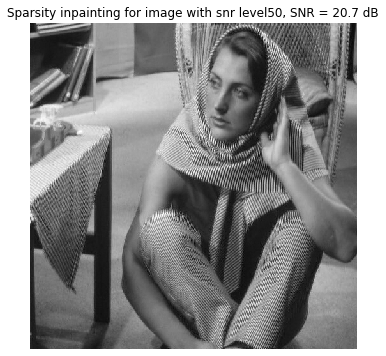

In [49]:
for snr in SNR_LIST:

  FISTA_warm(snr)

### Inpainting using Translation Invariant Wavelet Sparsity

**This part is an implementation of numerical tools**
Orthogonal sparsity performs a poor regularization because of the lack of translation invariance. This regularization is enhanced by considering Ψ as a redundant tight frame of translation invariant wavelets.


Load the image to be inpainted

Inpaint the imag with a certain Amount of removed pixels controlled with a bernouille distribution

we construct a mask Ω made of random pixel locations.

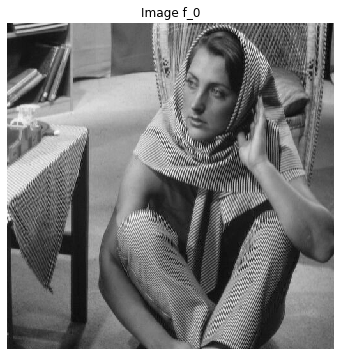

In [8]:
n = 512
f0 = load_image("/content/barbara.jpeg")
f0 = rescale(f0[256-n//2:256+n//2,256-n//2:256+n//2])
plt.figure(figsize = (6,6))
imageplot(f0, 'Image f_0')

In [9]:
rho = .7
from numpy import random

Omega = np.zeros([n, n])
sel = random.permutation(n**2)
np.ravel(Omega)[sel[np.arange(int(rho*n**2))]] = 1

The damaging operator put to zeros the pixel locations x for which Ω(x)=1

In [10]:
Phi = lambda f, Omega: f*(1-Omega)

The damaged observations reads y=Φf0.

In [11]:
y = Phi(f0, Omega)

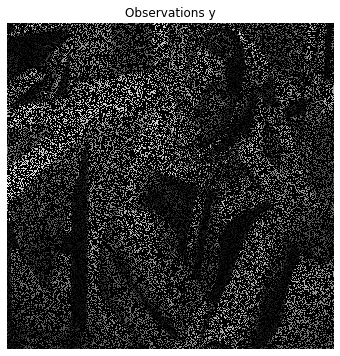

In [12]:
#display the observations
plt.figure(figsize = (6,6))
imageplot(y, 'Observations y')

Defining the soft thresholding

In [13]:
SoftThresh = lambda x, T: x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

In [14]:
SoftThreshPsi = lambda f, T: Psi(SoftThresh(PsiS(f), T))

In [15]:
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

In [16]:
from nt_toolbox.perform_wavelet_transf import *

Psi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=0)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, +1, ti=0)

Each iteration of the forward-backward (iterative thresholding) algorithm thus reads:
f(ℓ+1)=SΨλ(ProjC(f(ℓ))).

In [17]:
lambd = .03
ProjC = lambda f, Omega: Omega*f + (1-Omega)*y
fSpars = y
fSpars = ProjC(fSpars, Omega)
fSpars = SoftThreshPsi(fSpars, lambd)

In [18]:
#Compute the scaling factor (inverse of the redundancy).
J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (n,n,1)),(2,0,1))

In [19]:
#Choose a value of the regularization parameter.
lambd = .01

#Shortcut for the wavelet transform and the reconstruction.
Xi = lambda a: perform_wavelet_transf(a, Jmin, -1, ti=1)
PsiS = lambda f: perform_wavelet_transf(f, Jmin, + 1, ti=1)
Psi = lambda a: Xi(a/U)

# step size

tau = 1.9*np.min(u)

#Initialize the wavelet coefficients with those of the previous reconstruction.

a = U*PsiS(fSpars)
#Gradient descent.

fTI = Psi(a)
a = a + tau*PsiS(Phi(y-Phi(fTI, Omega), Omega))

#Soft threshold.
a = SoftThresh(a, lambd*tau)


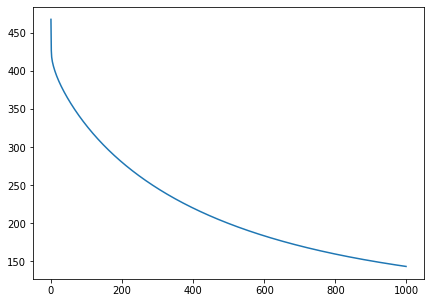

In [21]:
niter = 1000
a = U*PsiS(fSpars)
E = []
for i in range(niter):
    fTI = Psi(a)
    d = y-Phi(fTI, Omega)
    E = E + [1/2*linalg.norm(d , 'fro')**2 + lambd*np.sum(abs(a))]
    # step 
    a = SoftThresh(a + tau*PsiS(Phi(d, Omega)), lambd*tau)

plt.figure(figsize=(7,5))    
plt.plot(E)
plt.show()

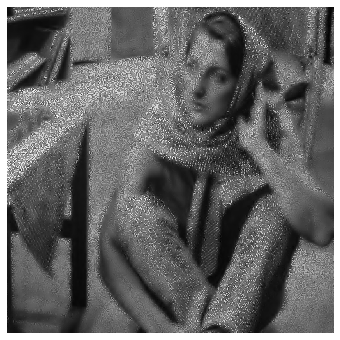

In [24]:
#Perform the reconstruction.
fTI = Psi(a)
#Display the result.
plt.figure(figsize=(6,6))
imageplot(clamp(fTI))

In this part, we are going to perform the iteration with a decaying value of λ

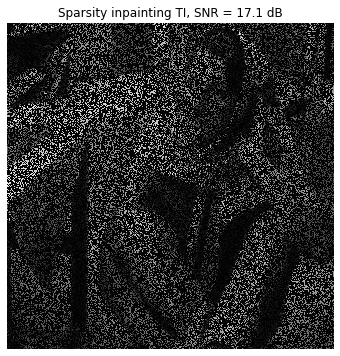

In [20]:
niter = 3000
lambda_list = np.linspace(.03, 0, niter)
err = []

for i in range(niter):
    fTI = Psi(a)
    d = y-Phi(fTI, Omega)
    #step
    a = SoftThresh(a + tau*PsiS(Phi(d, Omega)) , lambda_list[i]*tau) 


snr= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - fTI))  

plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), "Sparsity inpainting TI, SNR = %.1f dB" %snr)

### Inpainting using Iterative Hard Thresholding


To improve the sparsity of the solution, it is possible to replace the soft thresholding by a hard threshdoling. In this case, the resulting algorihtm does not perform anymore a variational minimization of an energy.

The hard thresholding is defined as hT(x)=0 if −T<x<T and hT(x)=x otherwise. It thus defines a thresholding operator of wavelet coefficients as HT(a)m=hT(am).

Define a shortcut for this vectorialized hard thresholding

In [22]:
HardThresh = lambda x, t: x*(abs(x) > t)
#Number of iterations.
niter = 500
#List of thresholds. One must start by a large enough initial threshold.
lambda_list = np.linspace(1, 0, niter)
#Initialization.
fHard = y
#Gradient descent.
fHard = ProjC(fHard, Omega)
#Hard threshold (here λ=λ0) is used).
fHard = Xi(HardThresh(PsiS(fHard), tau*lambda_list[1]))

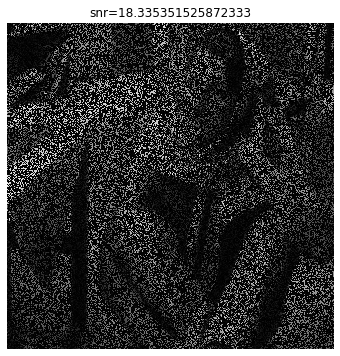

In [25]:
lambda_list = np.linspace(1, 0, niter)
fHard = y

for i in range(niter):
    fHard = Xi(HardThresh(PsiS(ProjC(fHard, Omega)), lambda_list[i]))

snr= 20 * np.log10(pylab.norm(f0) / pylab.norm(f0 - fHard))      
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), 'snr='+str(snr))

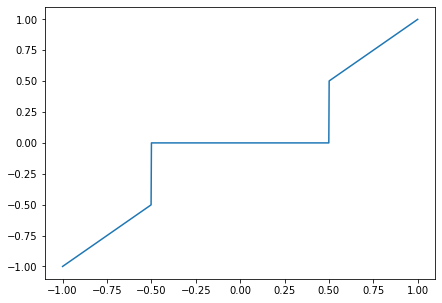

In [53]:
# Display a curve of the 1-D Hard thresholding.
x = np.linspace(-1, 1, 1000)

plt.figure(figsize=(7,5))
plt.plot(x, HardThresh(x, .5))
plt.show()

In [54]:
def fista_hard(snr):
  energy = [] # to track the energy
  alpha=np.zeros_like(img)
  z=np.zeros_like(img)
  iterations =100
  lambd = .03
  for i in range(iterations):
    a=HardThreshPsi(z+wavelet(A*(noisy_images[snr]-A*inv_wavelet(z))),lambd)
    z=a+(i/(i+5))*(a-alpha)
    alpha=a
    energy = energy + [1/2*linalg.norm(noisy_images[snr]-A*inv_wavelet(alpha),"fro")**2 + lambd*np.sum(abs(alpha))]
    denoised_image=inv_wavelet(alpha)
    
  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  fig.suptitle(f"SNR={snr}")
  axs[0].imshow(denoised_image,cmap='gray')
  axs[1].plot(energy, linewidth=2)
  axs[1].set_xlabel("Iteration")
  axs[1].set_ylabel("E")
  
  #return energy, denoised_image

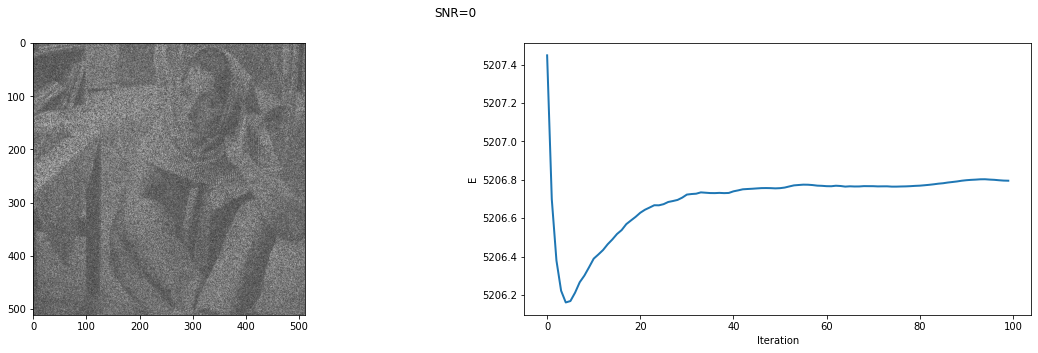

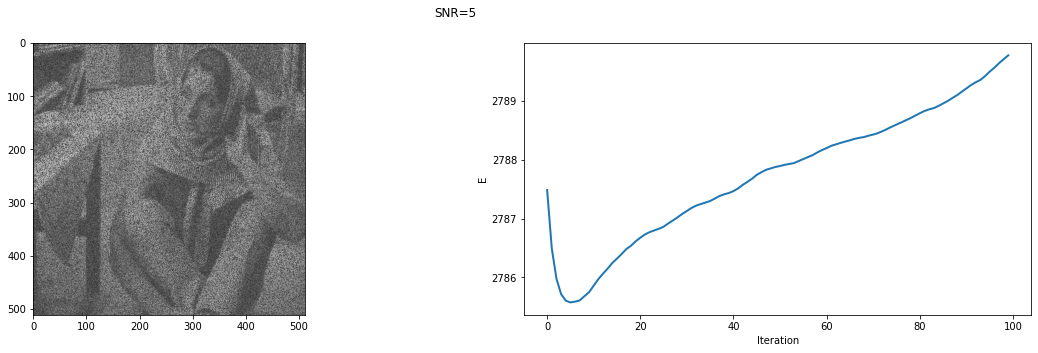

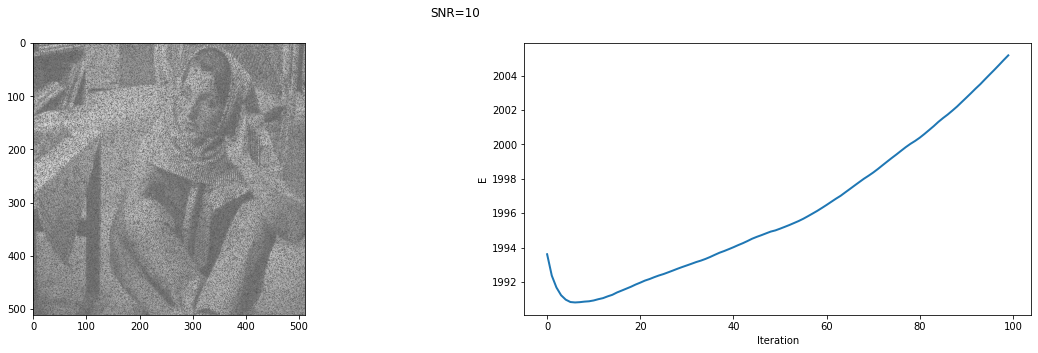

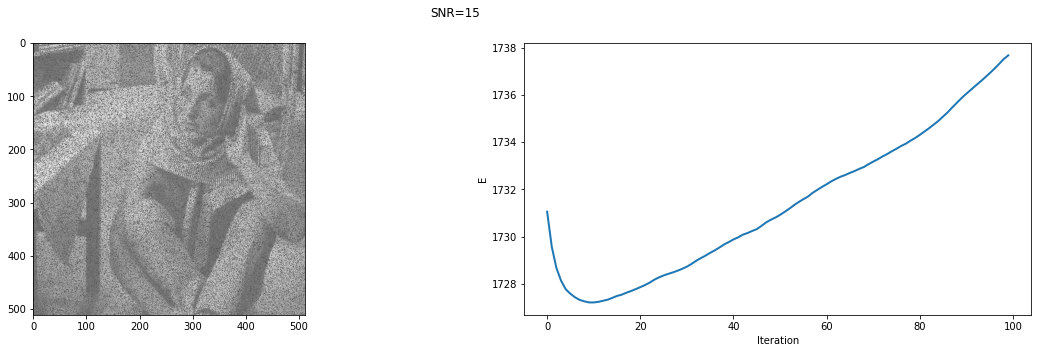

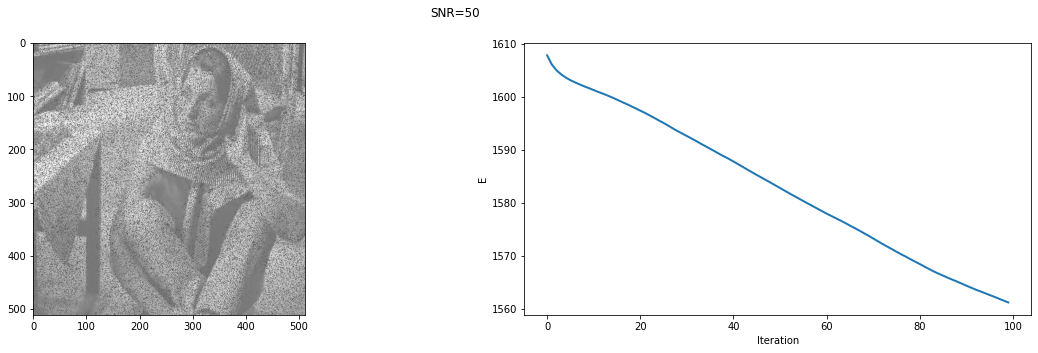

In [55]:
for snr in SNR_LIST:

  fista_hard(snr)

## Defining the soft thresholding

The soft thresholding operator is at the heart of ℓ1 minimization schemes. It can be applied to coefficients a, or to an image f in an ortho-basis.

The soft thresholding is a 1-D functional that shrinks the value of coefficients.
sT(u)=max(0,1−T/|u|)u
Define a shortcut for this soft thresholding 1-D functional.

## Inpainting using Orthogonal Wavelet Sparsity

If Ψ is an orthogonal basis, a change of variable shows that the synthesis prior is also an analysis prior, that reads
f⋆∈argminfE(f)=12‖y−Φf‖2+λ∑m‖⟨f,ψm⟩‖.
To solve this non-smooth optimization problem, one can use forward-backward splitting, also known as iterative soft thresholding.

It computes a series of images f(ℓ) defined as
f(ℓ+1)=SΨτλ(f(ℓ)−τΦ∗(Φf(ℓ)−y))
Set up the value of the threshold.

Set up the value of the threshold.

In [ ]:
lambd = .03

In our setting, we have Φ∗=Φ which is an operator of norm 1.

For f(ℓ) to converge to a solution of the problem, the gradient step size should be chosen as
τ<2‖Φ∗Φ‖=2
In the following we use:
τ=1
Since we use τ=1 and Φ=Φ∗=diag(1−Ω), the gradient descent step is a projection on the inpainting constraint
C={f∖∀Ω(x)=0,f(x)=y(x)}
One thus has
f−τΦ∗(Φf−y)=ProjC(f)
For the sake of simplicity, we define a shortcut for this projection operator.

In [ ]:
ProjC = lambda f, Omega: Omega*f + (1-Omega)*y

Each iteration of the forward-backward (iterative thresholding) algorithm thus reads:
f(ℓ+1)=SΨλ(ProjC(f(ℓ))).


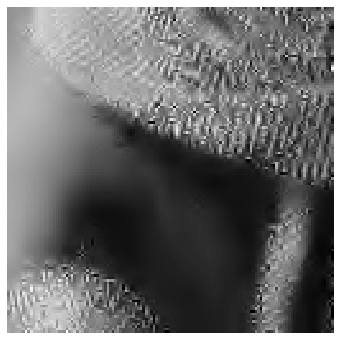

In [ ]:
iterations=200
fSpars = y #initialize the iterations
for i in range(iterations):
  fSpars = ProjC(fSpars, Omega) # First step: gradient descent.
  fSpars = SoftThreshPsi(fSpars, lambd) # Second step: denoise the solution by thresholding.
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars))

After we plotting the decay of the energy, we can observe that the curve is converged after around 100 of itrations. 
**why** **we use energy? how we define the function?**





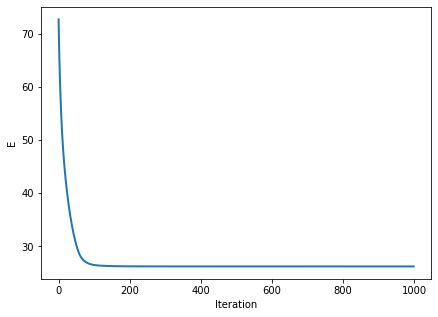

In [ ]:
from numpy import linalg
lambd=.03
fSpars = y
energy = []
niter = 1000
for i in range(niter):
    fSpars = SoftThreshPsi(ProjC(fSpars, Omega), lambd)
    # record the energy
    fW = PsiS(fSpars)
    energy = energy + [1/2*linalg.norm(y-Phi(fSpars, Omega),"fro")**2 + lambd*np.sum(abs(fW))]
    
plt.figure(figsize=(7,5))
plt.plot(energy, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("E")
plt.show()

Display the final image

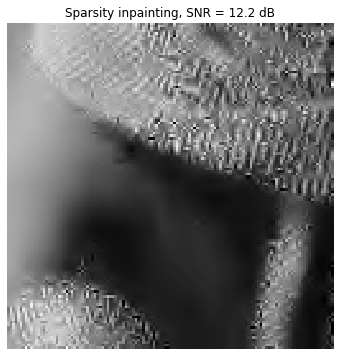

In [ ]:
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), "Sparsity inpainting, SNR = %.1f dB" %snr(f0, fSpars))

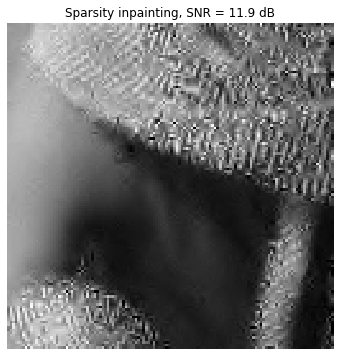

In [ ]:
niter = 1000
lambda_list = np.linspace(.03, 0, niter)
err = []

for i in range(niter):
    fSpars = SoftThreshPsi(ProjC(fSpars, Omega), lambda_list[i])
    
plt.figure(figsize=(6,6))
imageplot(clamp(fSpars), "Sparsity inpainting, SNR = %.1f dB" %snr(f0, fSpars))